# 1. Load some packages

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
/home/max/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 2. Clean and merge 311 complaint data and stabilization status data

In [34]:
data = pd.read_csv('http://taxbills.nyc/joined.csv',
                   usecols = ['borough', 'ucbbl', '2007uc',
                              '2008uc', '2009uc', '2010uc',
                              '2011uc', '2012uc', '2013uc',
                              '2014uc', 'cd', 'zipcode',
                              'unitsres'])
    
#
# Make a new row for each year
#
mdata = pd.melt(data, id_vars = ['borough', 'ucbbl', 'cd', 'zipcode',
                                 'unitsres'])
mdata.rename(columns = {'variable': 'year',
                        'value': 'Nstabilized'}, inplace = True)
mdata['year'] = mdata.apply(lambda x: np.int64(x.year[0:4]), axis = 1)

    
#
# Get rid of location identifiers that you're not interested in
#     for now
#
mdata.drop(['borough', 'ucbbl', 'cd'], axis = 1,
            inplace = True)
     
mdata = mdata.groupby(['zipcode', 'year']).sum().reset_index()

mdata['Pstabilized'] = mdata['Nstabilized'] / mdata['unitsres']


mdata.drop(['unitsres'], axis = 1, inplace = True)

In [35]:
mdata.head()

,zipcode,year,Nstabilized,Pstabilized
0,10001,2007,5195,0.532329
1,10001,2008,5222,0.535096
2,10001,2009,4703,0.481914
3,10001,2010,4628,0.474229
4,10001,2011,4835,0.495440


In [36]:
  
#
# Drop values with NA zipcodes
#
print(mdata.shape)
mdata.dropna(inplace = True)
print(mdata.shape)
mdata['zipcode'] = mdata['zipcode'].astype(int)
mdata['Nstabilized'] = mdata['Nstabilized'].astype(int)
print(mdata.dtypes)

#
# Save to CSV
#
mdata.to_csv('stabilized.csv', index = False)
    

(1416, 4)
(1406, 4)
zipcode          int64
year             int64
Nstabilized      int64
Pstabilized    float64
dtype: object


In [89]:
mdata.head(10)

,zipcode,year,Nstabilized,Pstabilized
0,10001,2007,5195,0.532329
1,10001,2008,5222,0.535096
2,10001,2009,4703,0.481914
3,10001,2010,4628,0.474229
4,10001,2011,4835,0.495440
5,10001,2012,5514,0.565017
6,10001,2013,5228,0.535711
7,10001,2014,5032,0.515627
8,10002,2007,9567,0.819935
9,10002,2008,9356,0.801851


In [88]:
data = pd.read_csv('data/311_Heat_Seek_Subset.csv', 
                   usecols = [1, 5, 8], header = None)
data.rename(columns = {1: 'year', 5: 'complaint_type', 8: 'zipcode'}, inplace = True)
data['year'] = data['year'].apply(lambda x: x[6:10])
data = data.groupby(['zipcode', 'year']).count().reset_index()
data.rename(columns = {'complaint_type': 'complaint_count'}, inplace = True)

data['year'] = data['year'].astype(np.int64)
data['zipcode'] = data['zipcode'].astype(np.int64)

data.head(10)

,zipcode,year,complaint_count
0,10001,2010,648
1,10001,2011,468
2,10001,2012,344
3,10001,2013,289
4,10001,2014,437
5,10001,2015,270
6,10002,2010,1226
7,10002,2011,1244
8,10002,2012,1264
9,10002,2013,1214


In [39]:
print(data.dtypes)
print(mdata.dtypes)

zipcode            int64
year               int64
complaint_count    int64
dtype: object
zipcode          int64
year             int64
Nstabilized      int64
Pstabilized    float64
dtype: object


In [40]:
merge_data = pd.merge(data, mdata, how = 'inner', on = ['zipcode', 'year'])
merge_data.head()

,zipcode,year,complaint_count,Nstabilized,Pstabilized
0,10001,2010,648,4628,0.474229
1,10001,2011,468,4835,0.495440
2,10001,2012,344,5514,0.565017
3,10001,2013,289,5228,0.535711
4,10001,2014,437,5032,0.515627


In [71]:
ind = np.where(np.isinf(merge_data['Pstabilized']))
ind
merge_data.iloc[255]
merge_data.drop(merge_data.index[np.where(np.isinf(merge_data['Pstabilized']))], inplace = True)
ind = np.where(np.isinf(merge_data['Pstabilized']))
ind

(array([], dtype=int64),)

In [72]:
merge_data.to_csv('jointdata.csv')

In [73]:
output_json = {}
output_json['type'] = 'zipcode_data_collection'
output_json['features'] = []

for zc in np.unique(merge_data['zipcode'].values):
    entry = {}
    entry['zipcode'] = zc
    
    entry['data'] = []
    hold = merge_data[merge_data.zipcode == zc]
    for ind, row in hold.iterrows():
        data_entry = {}
        data_entry['year'] = row['year']
        data_entry['complaint_count'] = row['complaint_count']
        data_entry['percent_stabilized'] = row['Pstabilized']
        data_entry['number_stabilized'] = row['Nstabilized']
        entry['data'].append(data_entry)
        
    output_json['features'].append(entry)

In [74]:
with open('jointdata.json', 'w') as f:
    json.dump(output_json, f)

# 2. Plot the data

In [37]:
income = pd.read_csv('data/incomes.csv')
income = income[income.key == 'gross income']
income.drop(['key', 'activitythrough'], axis = 1, inplace = True)
income.rename(columns = {'bbl': 'ucbbl', 'value': 'income'}, inplace = True)

data = pd.read_csv('http://taxbills.nyc/joined.csv',
                   usecols = ['borough', 'ucbbl', '2007uc',
                              '2008uc', '2009uc', '2010uc',
                              '2011uc', '2012uc', '2013uc',
                              '2014uc', 'cd', 'zipcode',
                              'unitsres', 'yearbuilt'])

    
#
# Make a new row for each year
#
mdata = pd.melt(data, id_vars = ['borough', 'ucbbl', 'cd', 'zipcode',
                                 'unitsres', 'yearbuilt'])
mdata.rename(columns = {'variable': 'year',
                        'value': 'Nstabilized'}, inplace = True)
mdata['year'] = mdata.apply(lambda x: np.int64(x.year[0:4]), axis = 1)


mdata = pd.merge(mdata, income, how = 'left', on = ['ucbbl', 'year'])

mdata['norm_income'] = mdata['income'] / mdata['unitsres']


mn = np.mean(mdata.norm_income[np.isfinite(mdata.norm_income)])
sd = np.std(mdata.norm_income[np.isfinite(mdata.norm_income)])

unmerged = mdata.copy()

In [38]:

mdata_filt = mdata[(mdata.yearbuilt <= 1948) & (mdata.norm_income < mn)].copy()

#
# Get rid of location identifiers that you're not interested in
#     for now
#
mdata_filt.drop(['borough', 'ucbbl', 'cd', 'yearbuilt', 'income'], axis = 1,
            inplace = True)
     

mdata_filt = mdata_filt.groupby(['zipcode', 'year']).sum().reset_index()


mdata_filt['Pstabilized'] = mdata_filt['Nstabilized'] / mdata_filt['unitsres']

# mdata.drop(['unitsres'], axis = 1, inplace = True)
mdata_filt.head()
mdata_filt.dropna(inplace = True)
mdata_filt['zipcode'] = mdata_filt['zipcode'].astype(int)
mdata_filt['Nstabilized'] = mdata_filt['Nstabilized'].astype(int)
mdata_filt.head(23)

,zipcode,year,unitsres,Nstabilized,norm_income,Pstabilized
0,10001,2007,1371,780,521641.226998,0.568928
1,10001,2008,1105,624,466587.629292,0.564706
2,10001,2009,678,414,378397.550364,0.610619
3,10001,2010,603,356,364789.266504,0.590381
4,10001,2011,520,314,282443.368031,0.603846
5,10001,2012,480,258,240511.568888,0.537500
6,10001,2013,546,313,264398.954663,0.573260
7,10001,2014,532,289,276440.027350,0.543233
8,10002,2007,6526,5357,3705195.742442,0.820870
9,10002,2008,6140,5031,3515309.470261,0.819381


In [39]:
#
# Get rid of location identifiers that you're not interested in
#     for now
#
mdata.drop(['borough', 'ucbbl', 'cd', 'yearbuilt', 'income'], axis = 1,
            inplace = True)
     

mdata = mdata.groupby(['zipcode', 'year']).sum().reset_index()


mdata['Pstabilized'] = mdata['Nstabilized'] / mdata['unitsres']

# mdata.drop(['unitsres'], axis = 1, inplace = True)
mdata.head()
mdata.dropna(inplace = True)
mdata['zipcode'] = mdata['zipcode'].astype(int)
mdata['Nstabilized'] = mdata['Nstabilized'].astype(int)
mdata.head(23)

,zipcode,year,unitsres,Nstabilized,norm_income,Pstabilized
0,10001,2007,9759,5195,inf,0.532329
1,10001,2008,9759,5222,inf,0.535096
2,10001,2009,9759,4703,inf,0.481914
3,10001,2010,9759,4628,inf,0.474229
4,10001,2011,9759,4835,inf,0.495440
5,10001,2012,9759,5514,inf,0.565017
6,10001,2013,9759,5228,inf,0.535711
7,10001,2014,9759,5032,inf,0.515627
8,10002,2007,11668,9567,inf,0.819935
9,10002,2008,11668,9356,inf,0.801851


In [40]:
# data = pd.read_csv('data/311_Heat_Seek_Subset.csv', 
#                    usecols = [1, 5, 8], header = None)
# data.rename(columns = {1: 'year', 5: 'complaint_type', 8: 'zipcode'}, inplace = True)
# data['year'] = data['year'].apply(lambda x: x[6:10])
# data = data.groupby(['zipcode', 'year']).count().reset_index()
# data.rename(columns = {'complaint_type': 'complaint_count'}, inplace = True)

# data['year'] = data['year'].astype(np.int64)
# data['zipcode'] = data['zipcode'].astype(np.int64)

# data.head(10)

In [42]:
# merge_data = pd.merge(data, mdata, how = 'inner', on = ['zipcode', 'year'])
# merge_data.head()

   year       zipcode     unitsres  Nstabilized     norm_income  Pstabilized
0  2007  10805.145695  4318.211921  3534.430464  1823947.518097     0.777445
1  2008  10813.151316  4219.671053  3442.092105  1850057.569250     0.769321
2  2009  10809.509934  4236.099338  3314.105960  1898055.103143     0.735209
3  2010  10804.986486  4179.486486  3288.175676  1921187.750322     0.721882
4  2011  10805.826667  3913.540000  3168.240000  1898406.743553     0.752556


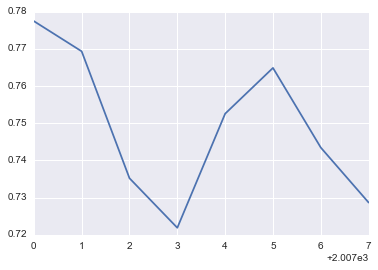

In [43]:
hold = mdata_filt.groupby('year').mean().reset_index()
print hold.head()
plt.plot(hold['year'], hold['Pstabilized'])

   year       zipcode     unitsres  Nstabilized  norm_income  Pstabilized
0  2007  10791.732558  8019.563953  5243.377907          inf     0.671308
1  2008  10805.640000  7892.862857  5081.182857          inf     0.662241
2  2009  10805.640000  7892.862857  4809.354286          inf     0.622462
3  2010  10807.540230  7936.643678  4834.132184          inf     0.625122
4  2011  10808.477011  7937.143678  4916.339080          inf     0.644552
5  2012  10799.388235  8112.111765  5124.717647          inf     0.660775
6  2013  10804.517241  7938.011494  5010.522989          inf     0.657936
7  2014  10787.792899  8052.751479  5018.976331          inf     0.654851


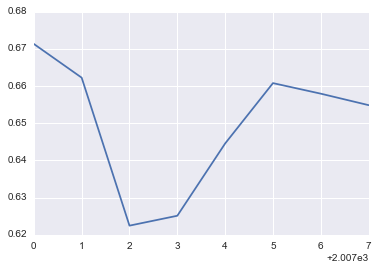

In [46]:
hold = mdata.groupby('year').mean().reset_index()
print hold
plt.plot(hold['year'], hold['Pstabilized'])

In [47]:
hold = unmerged.groupby('year').mean().reset_index()
print hold

   year       ucbbl          cd       zipcode   unitsres    yearbuilt  \
0  2007  2396764651  243.830016  10723.642832  30.857669  1922.323684   
1  2008  2396764651  243.830016  10723.642832  30.857669  1922.323684   
2  2009  2396764651  243.830016  10723.642832  30.857669  1922.323684   
3  2010  2396764651  243.830016  10723.642832  30.857669  1922.323684   
4  2011  2396764651  243.830016  10723.642832  30.857669  1922.323684   
5  2012  2396764651  243.830016  10723.642832  30.857669  1922.323684   
6  2013  2396764651  243.830016  10723.642832  30.857669  1922.323684   
7  2014  2396764651  243.830016  10723.642832  30.857669  1922.323684   

   Nstabilized         income  norm_income  
0    21.993978  445654.519928          inf  
1    21.653945  449446.834832          inf  
2    22.074943  456928.724410          inf  
3    22.302091  485414.685347          inf  
4    22.208400  492342.733470          inf  
5    22.155654  900155.858210          inf  
6    22.111937  518710.9544